In [52]:
import sys
sys.path.append('Coteach/training/')

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [362]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import h5py
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, Average,Dot
from sklearn import utils
from skimage import measure
from sklearn import metrics
from glob import glob
from scipy.stats import skew
import tensorflow as tf
import pickle
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import random
from model3 import CNN
from utils import *
from math import sqrt
from matplotlib.ticker import NullFormatter, FixedLocator

In [5]:
error_rates = ['01','05','10','20','30','40','42','46','48','50']

## MNIST analysis

### Data prep

In [199]:
data = keras.datasets.mnist.load_data()

In [333]:
seven_imgs_train = []
seven_labels_train = []
for idx,label in enumerate(data[0][1]):
    if label == 7:
        seven_imgs_train.append(data[0][0][idx])
        seven_labels_train.append(label)
seven_imgs_train = np.array(seven_imgs_train)
seven_labels_train = np.array(seven_labels_train)


new_left_images = []
new_left_labels = []
new_right_images = []
new_right_labels = []

for img in seven_imgs_train:
    new_left_images.append(np.fliplr(img))
    new_left_labels.append(0)
    new_right_images.append(img)
    new_right_labels.append(1)
new_left_images = np.array(new_left_images)
new_right_images = np.array(new_right_images)




X = utils.shuffle(np.concatenate((new_right_images,new_left_images),axis =0),random_state=0)
Y = utils.shuffle(np.concatenate((new_right_labels,new_left_labels),axis = 0),random_state=0)

train_split = int(len(X)*0.8)
val_split = train_split+int(len(X)*0.1)

# X_train = X[:train_split]
# X_test = X[train_split:val_split]
X_val = X[val_split:]
# Y_train = Y[:train_split]
# Y_test = Y[train_split:val_split]
Y_val = Y[val_split:]


X_val_norm = X_val/X_val.max()
X_val_norm = np.expand_dims(X_val_norm,axis=3)

In [339]:
right_val = np.array([im for idx,im in enumerate(X_val_norm) if Y_val[idx] == 1])
left_val = np.array([im for idx,im in enumerate(X_val_norm) if Y_val[idx] == 0])

### Define model

In [341]:
model = keras.models.Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(28, 28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

### Collect and plot results

In [342]:
error_rates_mnist = ['00','05','10','20','30','40','42','46','48','50']

In [208]:
acc_dict_mnist = {}
hand_ratio_dict_mnist = {}
lefts_dict_mnist = {}
rights_dict_mnist = {}
for e in error_rates_mnist:
    acc_dict_mnist[e] = []
    hand_ratio_dict_mnist[e]=[]
    lefts_dict_mnist[e] = []
    rights_dict_mnist[e] = []
    files = np.sort(glob('MNIST/weights/'+e+'perror_weight*'))
    for f in files:
        print(f.split('/')[-1])
        model.load_weights(f)
#         a, sd, sh = error_analysis(X_val,Y_val,modelE,diams,False)
        pred= model.predict(X_val_norm)
        a = metrics.accuracy_score(Y_val,pred>0.5)
        acc_dict_mnist[e].append(a)
        ratio, left, right = hand_ratios(Y_val,pred>0.5)
        hand_ratio_dict_mnist[e].append(ratio)
        lefts_dict_mnist[e].append(left)
        rights_dict_mnist[e].append(right)

00perror_weights_v9.h5
right:  1  left:  2
05perror_weights_v9.h5
right:  1  left:  2
10perror_weights_v9.h5
right:  1  left:  4
20perror_weights_v9.h5
right:  1  left:  5
30perror_weights_v9.h5
right:  1  left:  1
40perror_weights_v9.h5
right:  1  left:  9
42perror_weights_v9.h5
right:  6  left:  7
46perror_weights_v9.h5
right:  49  left:  40
48perror_weights_v9.h5
right:  149  left:  180
50perror_weights_v9.h5
right:  376  left:  391


In [209]:
avg_acc_mnist = []
acc_error_mnist = []
hand_dist_mnist = []
hand_error_mnist = []
errors_mnist = []
lefts_mnist = []
rights_mnist = []
for i in acc_dict_mnist:
    if len(acc_dict_mnist[i]) == 0:
        pass
    else:
        avg_acc_mnist.append(np.mean(acc_dict_mnist[i]))
        acc_error_mnist.append(np.std(acc_dict_mnist[i])/sqrt(len(acc_dict_mnist[i])))
        hand_dist_mnist.append(np.mean(hand_ratio_dict_mnist[i]))
        hand_error_mnist.append(np.std(hand_ratio_dict_mnist[i])/sqrt(len(hand_ratio_dict_mnist[i])))
        lefts_mnist.append(np.mean(lefts_dict_mnist[i]))
        rights_mnist.append(np.mean(rights_dict_mnist[i]))
        errors_mnist.append(int(i))

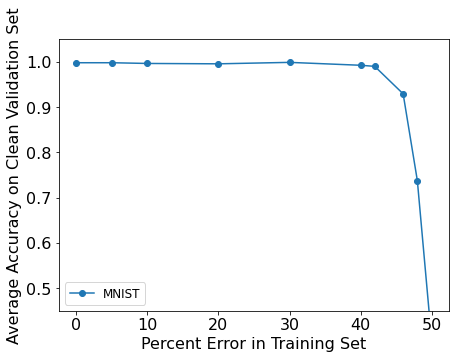

In [319]:
plt.figure(figsize=(7,5))
plt.plot(errors_mnist,avg_acc_mnist,'-o',label='MNIST')
plt.ylim([0.45,1.05])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.legend(fontsize=12,loc='lower left')
plt.ylabel('Average Accuracy on Clean Validation Set',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/mnist_acc.png',dpi=300,bbox_inches='tight')

Text(0.5, 0, 'Percent Error in Training Set')

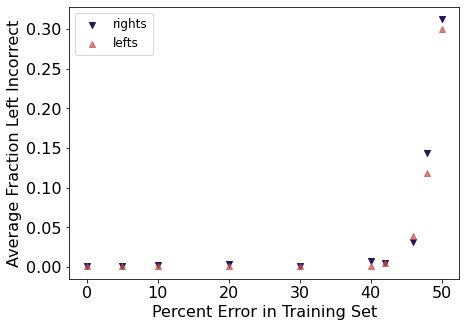

In [233]:
plt.figure(figsize=(7,5))
plt.scatter(errors_mnist,np.array(lefts_mnist)/len(X_val_norm),marker='v',label='rights',color = (39/256,20/256,88/256,1))
plt.scatter(errors_mnist,np.array(rights_mnist)/len(X_val_norm),marker='^',alpha=0.7,label='lefts',color = (191/256,79/256,74/256,1))
plt.legend(fontsize=12,loc=2)
# plt.ylim([0,0.3])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Average Fraction Left Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

Text(0.5, 0, 'Percent Error in Training Set')

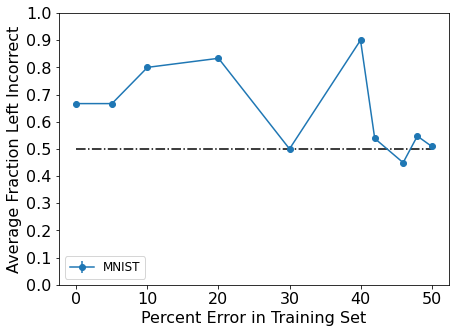

In [111]:
plt.figure(figsize=(7,5))
# plt.scatter(errors_basic,avg_skew_basic,marker='x',label='Basic CNN',alpha=0.7,color = (79/256,14/256,108/256,1))
plt.errorbar(errors_mnist,hand_dist_mnist,yerr=hand_error_mnist,marker='o',label='MNIST')
# plt.scatter(error_rates_coteach,avg_skew_coteach,marker='s',label='Co-Teaching',alpha=0.7,color = (247/256,130/256,16/256,1))
plt.plot(np.arange(0,55,5),np.ones((11,1))*0.5,'-.',color='k')
plt.legend(fontsize=12,loc=3)
plt.ylim([0,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(np.arange(0,1.1,0.1),fontsize=16)
plt.ylabel('Average Fraction Left Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

In [587]:
dif_mnist = {}
for idx,e in enumerate(errors_mnist):
    dif_mnist[e] = (lefts_mnist[idx],rights_mnist[idx])

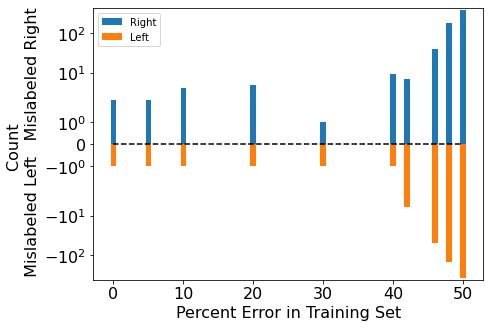

In [488]:
plt.figure(figsize=(7,5))
plt.bar(errors_mnist,lefts_mnist,label='Right')
plt.bar(errors_mnist,np.array(rights_mnist)*-1,label='Left')
plt.plot(errors_mnist,np.zeros((len(errors_mnist),)),'--',color = 'black')
plt.legend()
_=plt.xticks(fontsize=16)

ax = plt.gca()
ax.set_yscale('symlog',base=10)

# ax.set_yscale('function', functions=(forward, inverse))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_major_locator(FixedLocator([-100,-10,-1,0,1,10,100]))
plt.ylabel('Count \n Mislabeled Left   Mislabeled Right',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
_=plt.yticks([-100,-10,-1,0,1,10,100],fontsize=16)

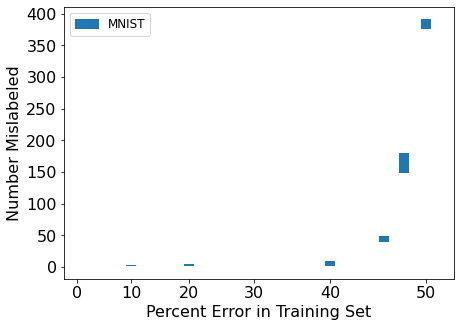

In [593]:
plt.figure(figsize=(7,5))
for key, values in dif_mnist.items():
    ymin, ymax = values
    if key == 50:
        plt.vlines(x=key, ymin=ymin, ymax=ymax, lw=10,label='MNIST')
    else:
        plt.vlines(x=key, ymin=ymin, ymax=ymax, lw=10)
plt.legend(loc=2,fontsize=12)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
ax = plt.gca()
ax.set_xscale('function', functions=(forward, inverse))
# ax.set_xscale('symlog')
# plt.xlim([0,60])
plt.ylabel('Number Mislabeled',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/mnist_error_count.png',dpi=300,bbox_inches='tight')

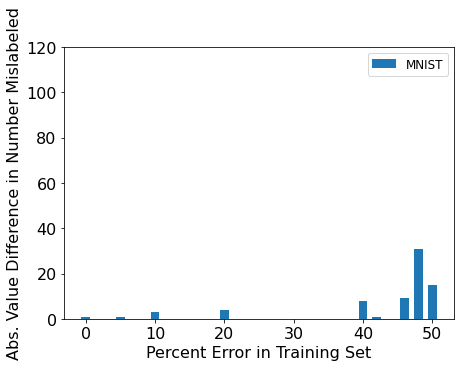

In [619]:
d_mnist = np.abs(np.array(lefts_mnist)-np.array(rights_mnist))


plt.figure(figsize=(7,5))
plt.bar(np.array(errors_mnist),d_mnist,label='MNIST',width=1.25)
plt.legend(fontsize=12)
_=plt.xticks(np.arange(0,60,10),fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Abs. Value Difference in Number Mislabeled',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
plt.ylim([0,120])
# ax = plt.gca()
# ax.set_xscale('function', functions=(forward, inverse))
# ax.set_yscale('log')
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/absval_num_mislabeled_mnist.png',dpi=300,bbox_inches='tight')

00perror_weights_v9.h5
0.003189792663476874
number of rights = 596  should be:  596  check:  596
05perror_weights_v9.h5
0.05263157894736842
number of rights = 564  should be:  564  check:  564
10perror_weights_v9.h5
0.10685805422647528
number of rights = 502  should be:  502  check:  502
20perror_weights_v9.h5
0.20414673046251994
number of rights = 439  should be:  439  check:  439
30perror_weights_v9.h5
0.3014354066985646
number of rights = 376  should be:  376  check:  376
40perror_weights_v9.h5
0.40350877192982454
number of rights = 364  should be:  364  check:  364
42perror_weights_v9.h5
0.4258373205741627
number of rights = 339  should be:  339  check:  339
46perror_weights_v9.h5
0.4609250398724083
number of rights = 326  should be:  326  check:  326
48perror_weights_v9.h5
0.5215311004784688
number of rights = 313  should be:  313  check:  313
50perror_weights_v9.h5
0.49122807017543857


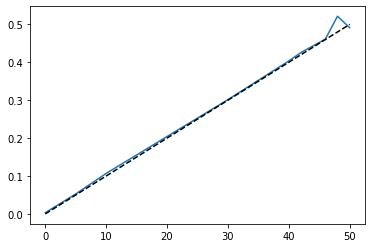

In [352]:
files = np.sort(glob('MNIST/weights/*_weights*'))
er_mnist, frc_mnist, frc_err_mnist = detected_fraction_left_MNIST(right_val,left_val,error_rates_mnist,files,model)
plt.plot(er_mnist,frc_mnist)
plt.plot(np.array(error_rates_mnist,dtype=int),np.array(error_rates_mnist,dtype=int)/100,'--',color='black')

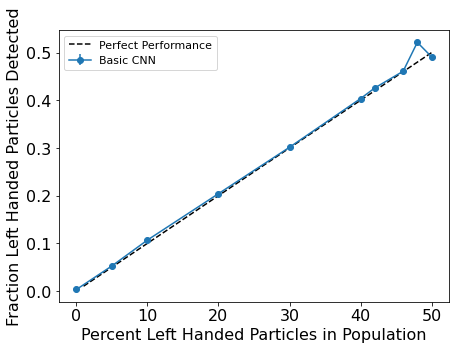

In [354]:
plt.figure(figsize=(7,5))
plt.errorbar(er_mnist,frc_mnist,yerr=frc_err_mnist,marker='o',label='Basic CNN')
plt.plot(np.array(error_rates_coteach2,dtype=float),np.array(error_rates_coteach2,dtype=float)/100,'--',color='black',label='Perfect Performance')
plt.legend(fontsize=11,loc=2)
# plt.ylim([0,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Fraction Left Handed Particles Detected',fontsize=16)
plt.xlabel('Percent Left Handed Particles in Population',fontsize=16)
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/left_detected_mnist.png',dpi=300,bbox_inches='tight')

## Basic CNN

### Data prep

In [225]:
right_images = h5py.File('Data/split_Chiral_D_Large_TIFF_Cropped_front_only.h5','r')['right_front'][:]
right_images2 = h5py.File('Data/split_Chiral_D_Large_TIFF_Cropped_right_front2.h5','r')['right_front'][:]

right_images = np.concatenate((right_images,right_images2),axis=0)
left_images = []

for img in right_images:
    left_images.append(np.fliplr(img))
left_images = np.array(left_images)

left_labels = [[0,1] for i in left_images]
right_labels = [[1,0] for i in right_images]

train_index = int(0.8*right_images.shape[0])
val_index = int(0.5*(right_images.shape[0]-train_index))+train_index
right_val = right_images[val_index:]
left_val = left_images[val_index:]
X_val = np.concatenate((left_val,right_val),axis=0)
Y_val = np.concatenate((left_labels[val_index:],right_labels[val_index:]),axis=0)
X_val, Y_val = utils.shuffle(X_val, Y_val,random_state=0)
X_val = X_val/X_val.max()
X_val = np.expand_dims(X_val,axis=3)
X_val = np.concatenate([X_val,X_val,X_val],axis=3)

### Define Model

In [226]:
modelE = keras.models.Sequential()
modelE.add(Conv2D(64, (3, 3), input_shape=(128, 128,3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(Activation('relu'))
modelE.add(MaxPooling2D(pool_size=(2, 2)))

modelE.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelE.add(Dense(64))
modelE.add(Activation('relu'))
modelE.add(Dropout(0.5))
modelE.add(Dense(2))
modelE.add(Activation('softmax'))

modelE.compile(loss='categorical_crossentropy',
              optimizer='Adadelta',
              metrics=['accuracy'])

### Collect and Plot Results

In [227]:
acc_dict_basic = {}
hand_ratio_dict_basic = {}
lefts_dict_basic = {}
rights_dict_basic = {}
for e in error_rates:
    acc_dict_basic[e] = []
    hand_ratio_dict_basic[e]=[]
    lefts_dict_basic[e] = []
    rights_dict_basic[e] = []
    files = glob('Basic_CNN/weights/*'+e+'perror_weights_v11n*')
    for f in files:
        print(f.split('/')[-1])
        modelE.load_weights(f)
        pred= modelE.predict(X_val)
        a = metrics.accuracy_score(Y_val,pred>0.5)
        acc_dict_basic[e].append(a)
        ratio, left,right = hand_ratios(Y_val,pred>0.5)
        hand_ratio_dict_basic[e].append(ratio)
        lefts_dict_basic[e].append(left)
        rights_dict_basic[e].append(right)

chiral_net_01perror_weights_v11n_ForLime_catcross_repeattrain_num0.h5
right:  6  left:  0
chiral_net_01perror_weights_v11n_v3_ForLime_catcross_repeattrain_num0.h5
right:  1  left:  2
chiral_net_01perror_weights_v11n_v2_ForLime_catcross_repeattrain_num0.h5
right:  3  left:  3
chiral_net_05perror_weights_v11n_ForLime_catcross_repeattrain_num0.h5
right:  4  left:  6
chiral_net_05perror_weights_v11n_v3_ForLime_catcross_repeattrain_num0.h5
right:  3  left:  7
chiral_net_05perror_weights_v11n_v2_ForLime_catcross_repeattrain_num0.h5
right:  3  left:  6
chiral_net_10perror_weights_v11n_v2_ForLime_catcross_repeattrain_num0.h5
right:  11  left:  6
chiral_net_10perror_weights_v11n_v3_ForLime_catcross_repeattrain_num0.h5
right:  9  left:  7
chiral_net_10perror_weights_v11n_ForLime_catcross_repeattrain_num0.h5
right:  7  left:  5
chiral_net_20perror_weights_v11n_v3_ForLime_catcross_repeattrain_num0.h5
right:  40  left:  42
chiral_net_20perror_weights_v11n_v2_ForLime_catcross_repeattrain_num0.h5
rig

In [228]:
avg_acc_basic = []
acc_error_basic = []
hand_dist_basic = []
hand_error_basic = []
errors_basic = []
lefts_basic = []
rights_basic = []
for i in acc_dict_basic:
    if len(acc_dict_basic[i]) == 0:
        pass
    else:
        avg_acc_basic.append(np.mean(acc_dict_basic[i]))
        acc_error_basic.append(np.std(acc_dict_basic[i])/sqrt(len(acc_dict_basic[i])))
        hand_dist_basic.append(np.mean(hand_ratio_dict_basic[i]))
        hand_error_basic.append(np.std(hand_ratio_dict_basic[i])/sqrt(len(hand_ratio_dict_basic[i])))
        lefts_basic.append(np.mean(lefts_dict_basic[i]))
        rights_basic.append(np.mean(rights_dict_basic[i]))
        errors_basic.append(int(i))

Text(0.5, 0, 'Percent Error in Training Set')

<Figure size 432x288 with 0 Axes>

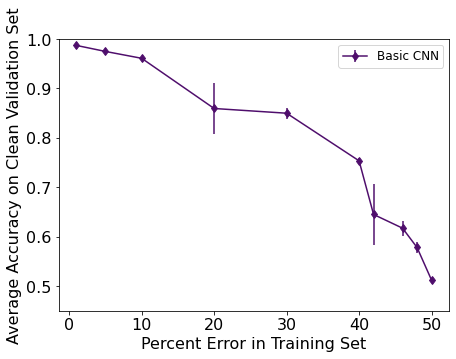

In [19]:
plt.set_cmap('plasma')
plt.figure(figsize=(7,5))
plt.errorbar(errors_basic,avg_acc_basic,yerr=acc_error_basic,marker='d',label='Basic CNN',color = (79/256,14/256,108/256,1))
# plt.errorbar(errors_tiny,avg_acc,yerr=acc_error,marker='o',label='Two Step Training',color = (197/256,61/256,77/256,1))
# plt.plot(error_rates_coteach,np.array(coteach_acc)/100,'-s',label='Co-Teaching',color = (247/256,130/256,16/256,1))
plt.legend(fontsize=12)
plt.ylim([0.45,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Average Accuracy on Clean Validation Set',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

Text(0.5, 0, 'Percent Error in Training Set')

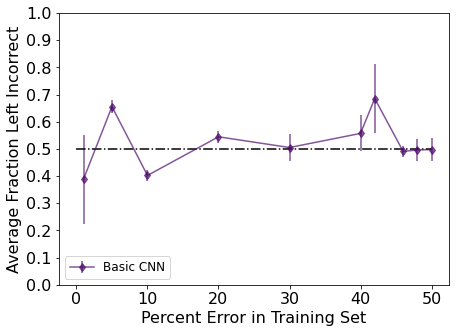

In [20]:
plt.figure(figsize=(7,5))
plt.errorbar(errors_basic,hand_dist_basic,yerr=hand_error_basic,marker='d',label='Basic CNN',alpha=0.7,color = (79/256,14/256,108/256,1))
# plt.errorbar(errors_tiny,hand_dist,yerr=hand_error,marker='o',label='Two Step Training',alpha=0.7,color = (197/256,61/256,77/256,1))
# plt.scatter(error_rates_coteach,avg_skew_coteach,marker='s',label='Co-Teaching',alpha=0.7,color = (247/256,130/256,16/256,1))
plt.plot(np.arange(0,55,5),np.ones((11,1))*0.5,'-.',color='k')
plt.legend(fontsize=12,loc=3)
plt.ylim([0,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(np.arange(0,1.1,0.1),fontsize=16)
plt.ylabel('Average Fraction Left Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

Text(0.5, 0, 'Percent Error in Training Set')

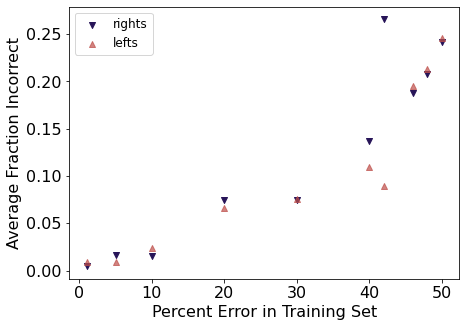

In [240]:
plt.figure(figsize=(7,5))
plt.scatter(errors_basic,np.array(lefts_basic)/len(X_val),marker='v',label='rights',color = (39/256,20/256,88/256,1))
plt.scatter(errors_basic,np.array(rights_basic)/len(X_val),marker='^',alpha=0.7,label='lefts',color = (191/256,79/256,74/256,1))
plt.legend(fontsize=12,loc=2)
# plt.ylim([0,0.3])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Average Fraction Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

number of rights = 190  should be:  190  check:  190
chiral_net_01perror_weights_v11n_ForLime_catcross_repeattrain_num0.h5
0.010416666666666666
chiral_net_01perror_weights_v11n_v2_ForLime_catcross_repeattrain_num0.h5
0.026041666666666668
chiral_net_01perror_weights_v11n_v3_ForLime_catcross_repeattrain_num0.h5
0.020833333333333332
number of rights = 182  should be:  182  check:  182
chiral_net_05perror_weights_v11n_ForLime_catcross_repeattrain_num0.h5
0.08333333333333333
chiral_net_05perror_weights_v11n_v2_ForLime_catcross_repeattrain_num0.h5
0.08333333333333333
chiral_net_05perror_weights_v11n_v3_ForLime_catcross_repeattrain_num0.h5
0.08854166666666667
number of rights = 173  should be:  173  check:  173
chiral_net_10perror_weights_v11n_ForLime_catcross_repeattrain_num0.h5
0.11458333333333333
chiral_net_10perror_weights_v11n_v2_ForLime_catcross_repeattrain_num0.h5
0.11458333333333333
chiral_net_10perror_weights_v11n_v3_ForLime_catcross_repeattrain_num0.h5
0.11458333333333333
number of 

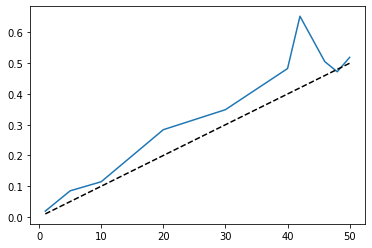

In [142]:
files = np.sort(glob('Basic_CNN/weights/*_weights*'))
er_basic, frc_basic, frc_err_basic = detected_fraction_left(right_val,left_val,error_rates,files,modelE)
plt.plot(er_basic,frc_basic)
plt.plot(np.array(error_rates,dtype=int),np.array(error_rates,dtype=int)/100,'--',color='black')

## Two Step

In [236]:
acc_dict_two = {}
hand_ratio_dict_two = {}
lefts_dict_two = {}
rights_dict_two = {}
for e in error_rates:
    acc_dict_two[e] = []
    hand_ratio_dict_two[e]=[]
    lefts_dict_two[e] = []
    rights_dict_two[e] = []
    files = glob('Two_Step/weights/*'+e+'perror_weights*')
    for f in files:
        print(f.split('/')[-1])
        modelE.load_weights(f)
        pred= modelE.predict(X_val)
        a = metrics.accuracy_score(Y_val,pred>0.5)
        acc_dict_two[e].append(a)
        ratio, left, right = hand_ratios(Y_val,pred>0.5)
        hand_ratio_dict_two[e].append(ratio)
        lefts_dict_two[e].append(left)
        rights_dict_two[e].append(right)

clean_net_01perror_weights_v10_0.h5
right:  4  left:  6
clean_net_01perror_weights_v10b_0.h5
right:  7  left:  3
clean_net_01perror_weights_v10b_1.h5
right:  8  left:  5
clean_net_05perror_weights_v10b_1.h5
right:  7  left:  10
clean_net_05perror_weights_v10b_0.h5
right:  9  left:  6
clean_net_10perror_weights_v10b_0.h5
right:  11  left:  9
clean_net_10perror_weights_v10b_1.h5
right:  10  left:  9
clean_net_20perror_weights_v10_0.h5
right:  11  left:  12
clean_net_20perror_weights_v10b_1.h5
right:  12  left:  12
clean_net_20perror_weights_v10b_0.h5
right:  11  left:  18
clean_net_30perror_weights_v10_0.h5
right:  19  left:  21
clean_net_30perror_weights_v10b_0.h5
right:  19  left:  21
clean_net_30perror_weights_v10b_1.h5
right:  17  left:  17
clean_net_40perror_weights_v10b_1.h5
right:  24  left:  25
clean_net_40perror_weights_v10b_0.h5
right:  26  left:  34
clean_net_40perror_weights_v10_0.h5
right:  28  left:  28
clean_net_42perror_weights_v10_0.h5
right:  31  left:  43
clean_net_42p

In [237]:
avg_acc_two = []
acc_error_two = []
hand_dist_two = []
hand_error_two = []
errors_two = []
lefts_two = []
rights_two = []
for i in acc_dict_two:
    if len(acc_dict_two[i]) == 0:
        pass
    else:
        avg_acc_two.append(np.mean(acc_dict_two[i]))
        acc_error_two.append(np.std(acc_dict_two[i])/sqrt(len(acc_dict_two[i])))
        hand_dist_two.append(np.mean(hand_ratio_dict_two[i]))
        hand_error_two.append(np.std(hand_ratio_dict_two[i])/sqrt(len(hand_ratio_dict_two[i])))
        lefts_two.append(np.mean(lefts_dict_two[i]))
        rights_two.append(np.mean(rights_dict_two[i]))
        errors_two.append(int(i))

Text(0.5, 0, 'Percent Error in Training Set')

<Figure size 432x288 with 0 Axes>

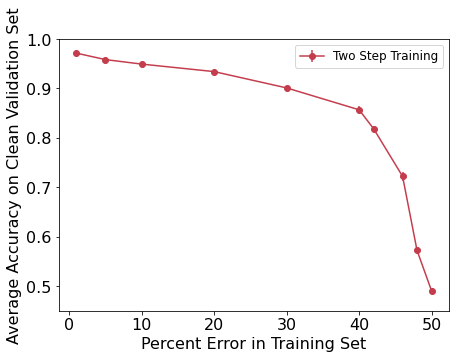

In [24]:
plt.set_cmap('plasma')
plt.figure(figsize=(7,5))
# plt.errorbar(errors_basic,avg_acc_basic,yerr=acc_error_basic,marker='d',label='Basic CNN',color = (79/256,14/256,108/256,1))
plt.errorbar(errors_two,avg_acc_two,yerr=acc_error_two,marker='o',label='Two Step Training',color = (197/256,61/256,77/256,1))
# plt.plot(error_rates_coteach,np.array(coteach_acc)/100,'-s',label='Co-Teaching',color = (247/256,130/256,16/256,1))
plt.legend(fontsize=12)
plt.ylim([0.45,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Average Accuracy on Clean Validation Set',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

Text(0.5, 0, 'Percent Error in Training Set')

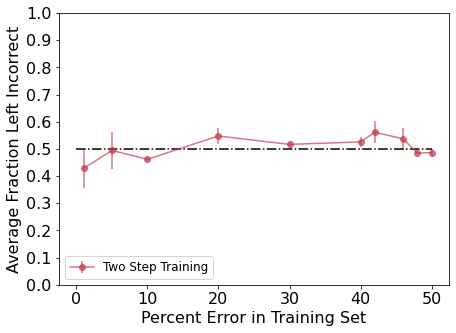

In [25]:
plt.figure(figsize=(7,5))
# plt.errorbar(errors_basic,hand_dist_basic,yerr=hand_error_basic,marker='d',label='Basic CNN',alpha=0.7,color = (79/256,14/256,108/256,1))
plt.errorbar(errors_two,hand_dist_two,yerr=hand_error_two,marker='o',label='Two Step Training',alpha=0.7,color = (197/256,61/256,77/256,1))
# plt.scatter(error_rates_coteach,avg_skew_coteach,marker='s',label='Co-Teaching',alpha=0.7,color = (247/256,130/256,16/256,1))
plt.plot(np.arange(0,55,5),np.ones((11,1))*0.5,'-.',color='k')
plt.legend(fontsize=12,loc=3)
plt.ylim([0,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(np.arange(0,1.1,0.1),fontsize=16)
plt.ylabel('Average Fraction Left Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

number of rights = 190  should be:  190  check:  190
clean_net_01perror_weights_v10_0.h5
0.041666666666666664
clean_net_01perror_weights_v10b_0.h5
0.026041666666666668
clean_net_01perror_weights_v10b_1.h5
0.036458333333333336
number of rights = 182  should be:  182  check:  182
clean_net_05perror_weights_v10b_0.h5
0.07291666666666667
clean_net_05perror_weights_v10b_1.h5
0.09375
number of rights = 173  should be:  173  check:  173
clean_net_10perror_weights_v10b_0.h5
0.13541666666666666
clean_net_10perror_weights_v10b_1.h5
0.13541666666666666
number of rights = 154  should be:  154  check:  154
clean_net_20perror_weights_v10_0.h5
0.24479166666666666
clean_net_20perror_weights_v10b_0.h5
0.2708333333333333
clean_net_20perror_weights_v10b_1.h5
0.24479166666666666
number of rights = 134  should be:  134  check:  134
clean_net_30perror_weights_v10_0.h5
0.3385416666666667
clean_net_30perror_weights_v10b_0.h5
0.3489583333333333
clean_net_30perror_weights_v10b_1.h5
0.3385416666666667
number of 

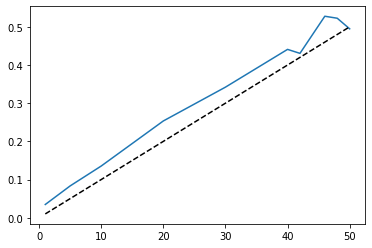

In [140]:
files = np.sort(glob('Two_Step/weights/*_weights*'))
er_two, frc_two, frc_err_two = detected_fraction_left(right_val,left_val,error_rates,files,modelE)
plt.plot(er_two,frc_two)
plt.plot(np.array(error_rates,dtype=int),np.array(error_rates,dtype=int)/100,'--',color='black')

## Co-Teach

### Data Prep

In [241]:
X = h5py.File('Data/split_Chiral_D_Large_TIFF_Cropped_front_only_combo_coteaching.h5','r')['val_images'][:]
Y = h5py.File('Data/split_Chiral_D_Large_TIFF_Cropped_front_only_combo_coteaching.h5','r')['val_labels'][:]
X = (X*255).astype('uint8')
X = X.transpose((0,3,1,2))
X = X/255

In [242]:
left_valX = X[:384//2]
right_valX = X[384//2:]

### Collect Results and Plot

In [243]:
error_rates_coteach = ['1.0p','5.0p','10.0p','20.0p','30.0p','40.0p','42.0p','46.0p','48.0p','50.0p']

In [244]:
device = torch.device('cpu')

In [246]:
acc_dict_coteach = {}
hand_ratio_dict_coteach = {}
lefts_dict_coteach = {}
rights_dict_coteach = {}
for error in error_rates_coteach:
    weights = glob('Coteach/weights/v24/*_'+error+'*v24*.pth')
    acc = []
    ratios = []
    rights = []
    lefts = []
    for weight in weights:
        torch.manual_seed(1)
        torch.cuda.manual_seed(1)
        cnn1 = CNN(input_channel=1, n_outputs=2)
        cnn1.load_state_dict(torch.load(weight, map_location=device))
        cnn1.eval()
        with torch.no_grad():
            pred = cnn1(torch.from_numpy(X).float())
        pred = F.softmax(pred, dim=1)
        _, plabel = pred.topk(1,1)
        a = accuracy(pred,torch.from_numpy(Y))
        acc.append(a[0].numpy()[0])
        ratio, left,right = hand_ratios(Y,plabel.numpy())
        ratios.append(ratio)
        rights.append(right)
        lefts.append(left)
    print(error,np.mean(acc))
    acc_dict_coteach[error] = acc
    hand_ratio_dict_coteach[error] = ratios
    lefts_dict_coteach[error] = lefts
    rights_dict_coteach[error] = rights

right:  4  left:  12
right:  9  left:  8
right:  7  left:  6
right:  5  left:  14
right:  4  left:  13
right:  7  left:  9
1.0p 95.74652
right:  11  left:  8
right:  11  left:  4
right:  15  left:  4
right:  11  left:  7
right:  9  left:  10
right:  12  left:  9
5.0p 95.18229
right:  8  left:  12
right:  14  left:  6
right:  7  left:  14
right:  14  left:  7
right:  10  left:  9
right:  6  left:  12
10.0p 94.83506
right:  6  left:  11
right:  13  left:  7
right:  6  left:  10
right:  9  left:  12
right:  7  left:  14
right:  7  left:  10
20.0p 95.138885
right:  18  left:  21
right:  18  left:  20
right:  20  left:  20
right:  18  left:  19
right:  17  left:  22
right:  14  left:  21
30.0p 90.104164
right:  21  left:  24
right:  21  left:  25
right:  24  left:  22
right:  25  left:  22
right:  22  left:  23
right:  20  left:  24
40.0p 88.15104
right:  25  left:  20
right:  26  left:  21
right:  24  left:  21
right:  23  left:  21
right:  26  left:  19
right:  26  left:  21
42.0p 88.1510

In [247]:
avg_acc_co = []
acc_error_co = []
hand_dist_co = []
hand_error_co = []
errors_co = []
lefts_co = []
rights_co = []
for i in acc_dict_coteach:
    if len(acc_dict_coteach[i]) == 0:
        pass
    else:
        avg_acc_co.append(np.mean(acc_dict_coteach[i]))
        acc_error_co.append(np.std(acc_dict_coteach[i])/sqrt(len(acc_dict_coteach[i])))
        hand_dist_co.append(np.mean(hand_ratio_dict_coteach[i]))
        hand_error_co.append(np.std(hand_ratio_dict_coteach[i])/sqrt(len(hand_ratio_dict_coteach[i])))
        lefts_co.append(np.mean(lefts_dict_coteach[i]))
        rights_co.append(np.mean(rights_dict_coteach[i]))
        errors_co.append(int(float(i.split('p')[0])))

Text(0.5, 0, 'Percent Error in Training Set')

<Figure size 432x288 with 0 Axes>

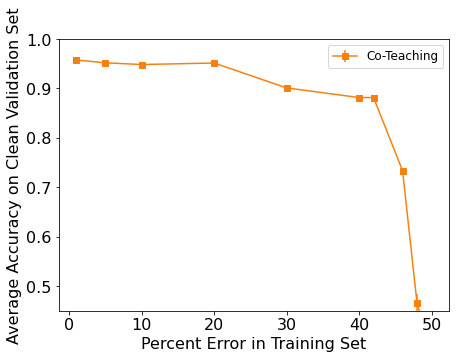

In [136]:
plt.set_cmap('plasma')
plt.figure(figsize=(7,5))
# plt.errorbar(errors_basic,avg_acc_basic,yerr=acc_error_basic,marker='d',label='Basic CNN',color = (79/256,14/256,108/256,1))
# plt.errorbar(errors_two,avg_acc_two,yerr=acc_error_two,marker='o',label='Two Step Training',color = (197/256,61/256,77/256,1))
plt.errorbar(errors_co,np.array(avg_acc_co)/100,yerr=np.array(acc_error_co)/100,marker='s',label='Co-Teaching',color = (247/256,130/256,16/256,1))
plt.legend(fontsize=12)
plt.ylim([0.45,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Average Accuracy on Clean Validation Set',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

Text(0.5, 0, 'Percent Error in Training Set')

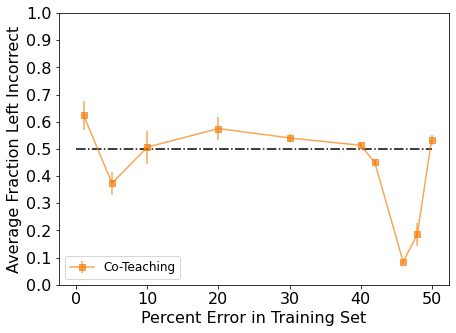

In [137]:
plt.figure(figsize=(7,5))
# plt.errorbar(errors_basic,hand_dist_basic,yerr=hand_error_basic,marker='d',label='Basic CNN',alpha=0.7,color = (79/256,14/256,108/256,1))
# plt.errorbar(errors_two,hand_dist_two,yerr=hand_error_two,marker='o',label='Two Step Training',alpha=0.7,color = (197/256,61/256,77/256,1))
plt.errorbar(errors_co,hand_dist_co,yerr=hand_error_co,marker='s',label='Co-Teaching',alpha=0.7,color = (247/256,130/256,16/256,1))
plt.plot(np.arange(0,55,5),np.ones((11,1))*0.5,'-.',color='k')
plt.legend(fontsize=12,loc=3)
plt.ylim([0,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(np.arange(0,1.1,0.1),fontsize=16)
plt.ylabel('Average Fraction Left Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

Text(0.5, 0, 'Percent Error in Training Set')

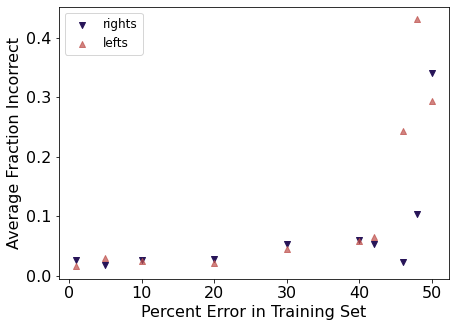

In [248]:
plt.figure(figsize=(7,5))
plt.scatter(errors_co,np.array(lefts_co)/len(X),marker='v',label='rights',color = (39/256,20/256,88/256,1))
plt.scatter(errors_co,np.array(rights_co)/len(X),marker='^',alpha=0.7,label='lefts',color = (191/256,79/256,74/256,1))
plt.legend(fontsize=12,loc=2)
# plt.ylim([0,0.3])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Average Fraction Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)

In [45]:
error_rates_coteach2 = [e.split('p')[0] for e in error_rates_coteach]

In [ ]:
acc_error_co.append(np.std(acc_dict_coteach[i])/sqrt(len(acc_dict_coteach[i])))

number of rights = 190  should be:  190  check:  190
chiral_coteaching_chiral_flip_1.0p_v24b2021-04-19-15:36:32_cnn1.pth
0.0625
chiral_coteaching_chiral_flip_1.0p_v24a2021-04-19-15:35:31_cnn1.pth
0.078125
chiral_coteaching_chiral_flip_1.0p_v24c2021-04-19-15:41:32_cnn1.pth
0.08854166666666667
number of rights = 182  should be:  182  check:  182
chiral_coteaching_chiral_flip_5.0p_v24c2021-04-19-15:41:33_cnn1.pth
0.10416666666666667
chiral_coteaching_chiral_flip_5.0p_v24a2021-04-19-15:35:31_cnn1.pth
0.08854166666666667
chiral_coteaching_chiral_flip_5.0p_v24b2021-04-19-15:36:33_cnn1.pth
0.109375
number of rights = 173  should be:  173  check:  173
chiral_coteaching_chiral_flip_10.0p_v24a2021-04-19-15:35:31_cnn1.pth
0.11458333333333333
chiral_coteaching_chiral_flip_10.0p_v24b2021-04-19-15:36:37_cnn1.pth
0.125
chiral_coteaching_chiral_flip_10.0p_v24c2021-04-19-15:41:33_cnn1.pth
0.11458333333333333
number of rights = 154  should be:  154  check:  154
chiral_coteaching_chiral_flip_20.0p_v24a20

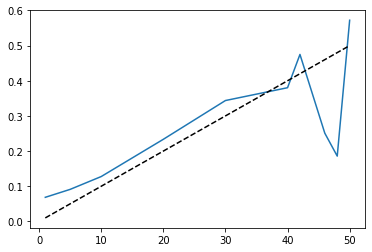

In [141]:
files = glob('Coteach/weights/v24/*v24*cnn1.pth')
er_co, frc_co, frc_err_co = detected_fraction_left_coteach(right_valX,left_valX,error_rates_coteach2,files)
plt.plot(er_coteach,frc_coteach)
plt.plot(np.array(error_rates_coteach2,dtype=float),np.array(error_rates_coteach2,dtype=float)/100,'--',color='black')

## Combined Results

<Figure size 432x288 with 0 Axes>

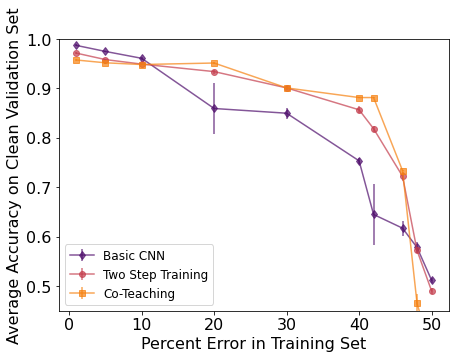

In [102]:
plt.set_cmap('plasma')
plt.figure(figsize=(7,5))
plt.errorbar(errors_basic,avg_acc_basic,yerr=acc_error_basic,marker='d',label='Basic CNN',alpha=0.7,color = (79/256,14/256,108/256,1))
plt.errorbar(errors_two,avg_acc_two,yerr=acc_error_two,marker='o',label='Two Step Training',alpha=0.7,color = (197/256,61/256,77/256,1))
plt.errorbar(errors_co,np.array(avg_acc_co)/100,yerr=np.array(acc_error_co)/100,marker='s',label='Co-Teaching',alpha=0.7,color = (247/256,130/256,16/256,1))
plt.legend(fontsize=12)
plt.ylim([0.45,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Average Accuracy on Clean Validation Set',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/avg_acc.png',dpi=300,bbox_inches='tight')

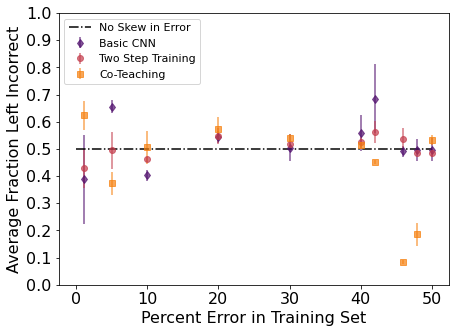

In [138]:
plt.figure(figsize=(7,5))
plt.errorbar(errors_basic,hand_dist_basic,yerr=hand_error_basic,fmt='d',label='Basic CNN',alpha=0.7,color = (79/256,14/256,108/256,1))
plt.errorbar(errors_two,hand_dist_two,yerr=hand_error_two,fmt='o',label='Two Step Training',alpha=0.7,color = (197/256,61/256,77/256,1))
plt.errorbar(errors_co,hand_dist_co,yerr=hand_error_co,fmt='s',label='Co-Teaching',alpha=0.7,color = (247/256,130/256,16/256,1))
plt.plot(np.arange(0,55,5),np.ones((11,1))*0.5,'-.',color='k',label = 'No Skew in Error' )
plt.legend(fontsize=11,loc=2)
plt.ylim([0,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(np.arange(0,1.1,0.1),fontsize=16)
plt.ylabel('Average Fraction Left Incorrect',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/left_incorrect.png',dpi=300,bbox_inches='tight')

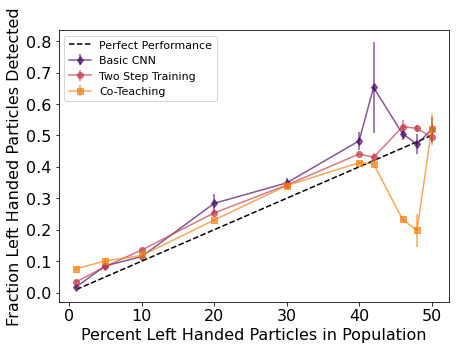

In [145]:
plt.figure(figsize=(7,5))
plt.errorbar(er_basic,frc_basic,yerr=frc_err_basic,marker='d',label='Basic CNN',alpha=0.7,color = (79/256,14/256,108/256,1))
plt.errorbar(er_two,frc_two,yerr=frc_err_two,marker='o',label='Two Step Training',alpha=0.7,color = (197/256,61/256,77/256,1))
plt.errorbar(er_co,frc_co,yerr=frc_err_co,marker='s',label='Co-Teaching',alpha=0.7,color = (247/256,130/256,16/256,1))
plt.plot(np.array(error_rates_coteach2,dtype=float),np.array(error_rates_coteach2,dtype=float)/100,'--',color='black',label='Perfect Performance')
plt.legend(fontsize=11,loc=2)
# plt.ylim([0,1])
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Fraction Left Handed Particles Detected',fontsize=16)
plt.xlabel('Percent Left Handed Particles in Population',fontsize=16)
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/left_detected.png',dpi=300,bbox_inches='tight')

In [512]:
dif_co = {}
dif_two = {}
dif_basic = {}
for idx,e in enumerate(errors_co):
    dif_co[e] = (lefts_co[idx]/len(X_val),rights_co[idx]/len(X_val))
    dif_two[e] = (lefts_two[idx]/len(X_val),rights_two[idx]/len(X_val))
    dif_basic[e] = (lefts_basic[idx]/len(X),rights_basic[idx]/len(X))

Text(0.5, 0, 'Percent Error in Training Set')

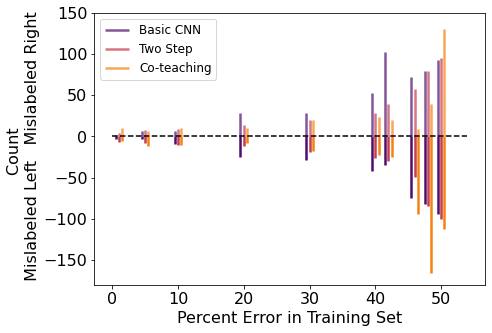

In [552]:
plt.figure(figsize=(7,5))
plt.vlines(np.array(errors_basic)-0.5,ymin=np.zeros((len(lefts_basic),1)),ymax=lefts_basic, lw=2.5,color=(79/256,14/256,108/256,0.7),label='Basic CNN')
plt.vlines(np.array(errors_basic)-0.5,ymin=np.array(rights_basic)*-1,ymax=np.zeros((len(rights_basic),1)), lw=2.5,color=(79/256,14/256,108/256,1))
plt.vlines(errors_basic,ymin=np.zeros((len(lefts_two),1)),ymax=lefts_two, lw=2.5,color=(197/256,61/256,77/256,0.7),label='Two Step')
plt.vlines(errors_basic,ymin=np.array(rights_two)*-1,ymax=np.zeros((len(rights_basic),1)), lw=2.5,color=(197/256,61/256,77/256,1))
plt.vlines(np.array(errors_basic)+0.5,ymin=np.zeros((len(lefts_co),1)),ymax=lefts_co, lw=2.5,color=(247/256,130/256,16/256,0.7),label='Co-teaching')
plt.vlines(np.array(errors_basic)+0.5,ymin=np.array(rights_co)*-1,ymax=np.zeros((len(rights_basic),1)), lw=2.5,color=(247/256,130/256,16/256,1))
plt.plot(np.arange(0,55,2),np.zeros(len(np.arange(0,55,2)),),'--',color='black')
plt.legend(loc=2,fontsize=12)
_=plt.xticks(np.arange(0,60,10),fontsize=16)
_=plt.yticks(np.arange(-150,160,50),fontsize=16)
plt.ylabel('Count \n Mislabeled Left   Mislabeled Right',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
# ax = plt.gca()
# ax.set_xscale('function', functions=(forward, inverse))

In [554]:
d_basic = np.abs(np.array(lefts_basic)-np.array(rights_basic))
d_two = np.abs(np.array(lefts_two)-np.array(rights_two))
d_co = np.abs(np.array(lefts_co)-np.array(rights_co))

In [ ]:
#For changing x-axis scaling
def forward(a):
    a = np.deg2rad(a)
    return np.rad2deg(np.log(np.abs(np.tan(a) + 1.0 / np.cos(a))))


def inverse(a):
    a = np.deg2rad(a)
    return np.rad2deg(np.arctan(np.sinh(a)))

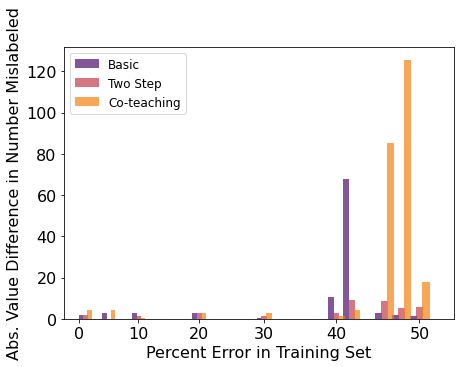

In [613]:
plt.figure(figsize=(7,5))
plt.bar(np.array(errors_basic)-0.7,d_basic,label='Basic', color = (79/256,14/256,108/256,0.7),width=0.8)
plt.bar(np.array(errors_two),d_two,label='Two Step',color=(197/256,61/256,77/256,0.7),width=0.8)
plt.bar(np.array(errors_co)+0.7,d_co,label='Co-teaching',color=(247/256,130/256,16/256,0.7),width=0.8)
plt.legend(fontsize=12)
_=plt.xticks(np.arange(0,60,10),fontsize=16)
_=plt.yticks(fontsize=16)
plt.ylabel('Abs. Value Difference in Number Mislabeled',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
ax = plt.gca()
ax.set_xscale('function', functions=(forward, inverse))
# ax.set_yscale('log')
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/absval_num_mislabeled.png',dpi=300,bbox_inches='tight')

In [536]:
dif_co = {}
dif_two = {}
dif_basic = {}
for idx,e in enumerate(errors_co):
    dif_co[e] = (lefts_co[idx],rights_co[idx])
    dif_two[e] = (lefts_two[idx],rights_two[idx])
    dif_basic[e] = (lefts_basic[idx],rights_basic[idx])

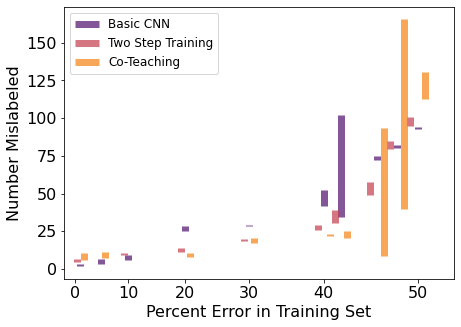

In [586]:
plt.figure(figsize=(7,5))
for key, values in dif_basic.items():
    ymin, ymax = values
    if key == 50:
        plt.vlines(x=key, ymin=ymin, ymax=ymax, lw=7,color=(79/256,14/256,108/256,1),label='Basic CNN',alpha=0.7)
    else:
        plt.vlines(x=key, ymin=ymin, ymax=ymax, lw=7,color=(79/256,14/256,108/256,1),alpha=0.7)
for key, values in dif_two.items():
    ymin, ymax = values
    if key == 50:
        plt.vlines(x=key-0.7, ymin=ymin, ymax=ymax, lw=7,color=(197/256,61/256,77/256,1),alpha=0.7,label='Two Step Training')
    else:
        plt.vlines(x=key-0.7, ymin=ymin, ymax=ymax, lw=7,color=(197/256,61/256,77/256,1),alpha=0.7)
for key, values in dif_co.items():
    ymin, ymax = values
    if key == 50:
        plt.vlines(x=key+0.7, ymin=ymin, ymax=ymax, lw=7,color=(247/256,130/256,16/256,1),label='Co-Teaching',alpha=0.7)
    else:
        plt.vlines(x=key+0.7, ymin=ymin, ymax=ymax, lw=7,color=(247/256,130/256,16/256,1),alpha=0.7)
# plt.ylim([0,0.5])
plt.legend(loc=2,fontsize=12)
_=plt.xticks(fontsize=16)
_=plt.yticks(fontsize=16)
ax = plt.gca()
ax.set_xscale('function', functions=(forward, inverse))
# ax.set_xscale('symlog')
# plt.xlim([0,60])
plt.ylabel('Number Mislabeled',fontsize=16)
plt.xlabel('Percent Error in Training Set',fontsize=16)
plt.savefig('/Users/cgroschner/Desktop/Noisy_label_paper_figs/new_results/te_error_count.png',dpi=300,bbox_inches='tight')